In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
from sklearn.utils import shuffle
from PIL import Image
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [10]:
from glob import glob
class CADMRIDataset(Dataset):
    
    def __init__(self,data_dir,reshape=True,height=128,width=128,autoencoder=False):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.autoencoder = autoencoder
        
        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]
        
        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })
        
        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)
        
    def __len__(self):
        return len(self.no_class)+len(self.yes_class)
    
    def __getitem__(self,idx):
        
        image_list = self.dataframe['image'][idx]
        label_list = self.dataframe['labels'][idx]
        
        if type(image_list) == str:
            image_list = [image_list]

        if not isinstance(label_list,np.int64):
            label_list = label_list.values

        image_array = []
        for image in image_list:
            image = Image.open(image).convert("L")
            if self.reshape:
                image = image.resize((self.height,self.width))

            array = np.asarray(image)
        
            if self.autoencoder:
                array = array.reshape(self.height*self.width)
            else:
                array = array.reshape(1,self.height,self.width)
            
            image_array.append(array)
        
        return [torch.tensor(image_array,device=device),torch.tensor(label_list,device=device)]
    
    def __repr__(self):
        return str(self.dataframe.head())

In [11]:
dataset = CADMRIDataset('dataset')
print(dataset)

                            image  labels
0  dataset/no\img0033-55.6674.jpg       0
1   dataset/yes\IM00018 (347).jpg       1
2   dataset/yes\IM00020 (302).jpg       1
3   dataset/yes\IM00018 (240).jpg       1
4  dataset/no\img0031-67.4379.jpg       0


In [12]:
dataset_autoencoder = CADMRIDataset('dataset',autoencoder=True,height=28,width=28)

In [23]:
class CADAutoencodes(nn.Module):
    
    def __init__(self,dim):
        
        super().__init__()
        self.lin1 = nn.Linear(dim*dim,542)
        self.lin2 = nn.Linear(542,345)
        self.lin3 = nn.Linear(345,128)
        self.lin4 = nn.Linear(128,64)
        self.lin5 = nn.Linear(64,32)
        self.lin6 = nn.Linear(32,64)
        self.lin7 = nn.Linear(64,128)
        self.lin8 = nn.Linear(128,345)
        self.lin9 = nn.Linear(345,542)
        self.lin10 = nn.Linear(542,dim*dim)

    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = self.lin5(x)
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = self.lin8(x)
        x = F.relu(self.lin9(x))
        x = F.relu(self.lin10(x))

        return x

In [24]:
autoencoder = CADAutoencodes(28)
autoencoder.to(device)

CADAutoencodes(
  (lin1): Linear(in_features=784, out_features=542, bias=True)
  (lin2): Linear(in_features=542, out_features=345, bias=True)
  (lin3): Linear(in_features=345, out_features=128, bias=True)
  (lin4): Linear(in_features=128, out_features=64, bias=True)
  (lin5): Linear(in_features=64, out_features=32, bias=True)
  (lin6): Linear(in_features=32, out_features=64, bias=True)
  (lin7): Linear(in_features=64, out_features=128, bias=True)
  (lin8): Linear(in_features=128, out_features=345, bias=True)
  (lin9): Linear(in_features=345, out_features=542, bias=True)
  (lin10): Linear(in_features=542, out_features=784, bias=True)
)

In [25]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())

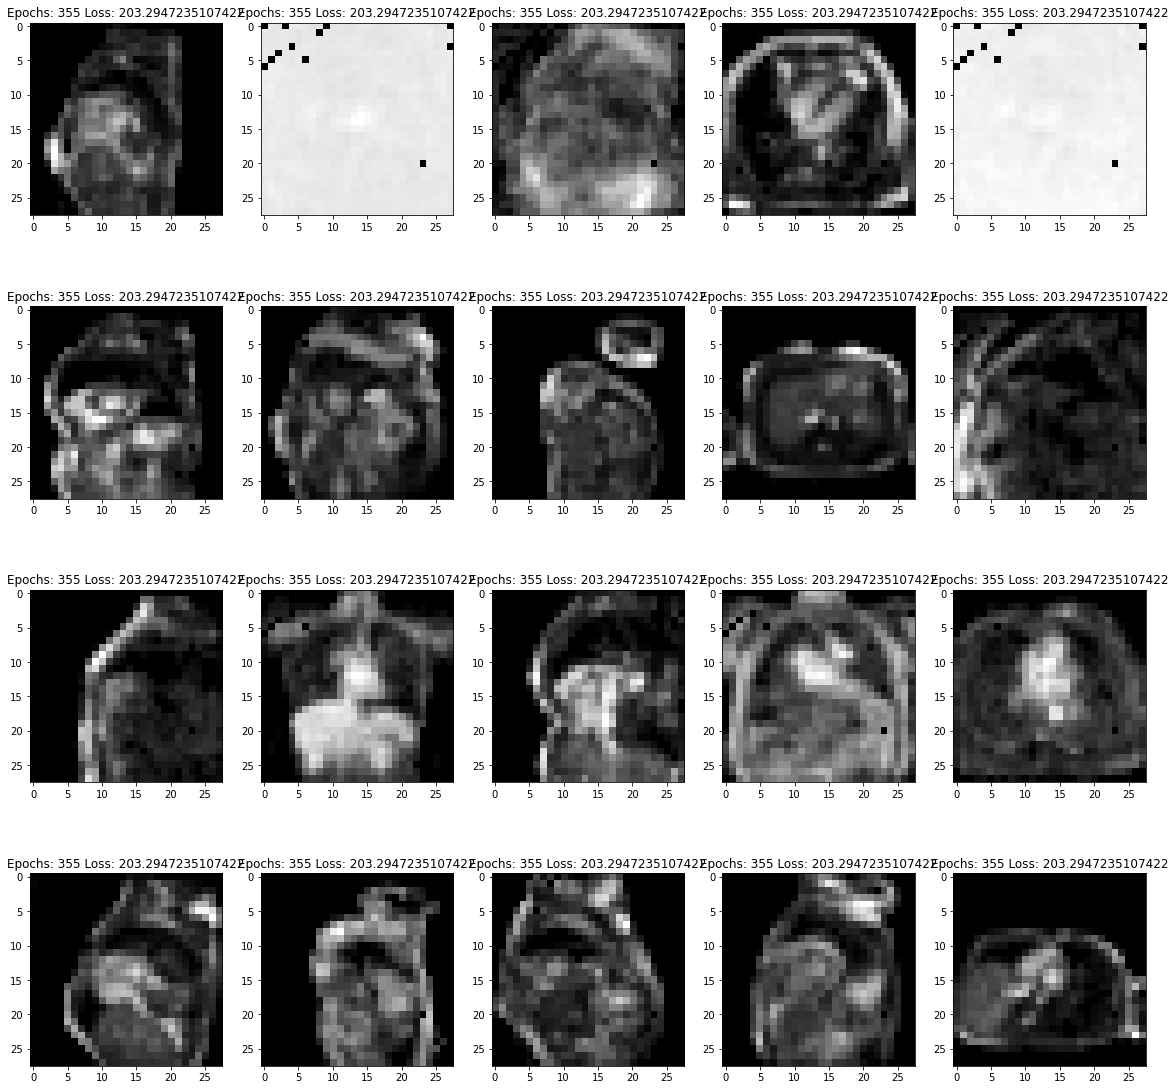

In [26]:
from IPython.display import clear_output
epochs = 500
batch_size = 32
loss_list = []
for epoch in range(epochs):
    clear_output(True)
    total_loss = 0
    for n in range(len(dataset_autoencoder)//batch_size):
    
        data,target = dataset_autoencoder[n*batch_size:(n+1)*batch_size]

        ypred = autoencoder.forward(data.float())
        loss = loss_fn(ypred,data.float())

        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    loss_list.append(total_loss/batch_size)
    
    figure = plt.figure(figsize=(20,20))
    for i in range(20):
        plt.subplot(4,5,i+1)
        image = ypred[i].cpu().detach().numpy()
        image = image.reshape(28,28)
        fig = plt.figure
        plt.imshow(image, cmap='gray')
        plt.title(f'Epochs: {epoch} Loss: {total_loss/n}')
    plt.show()